In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Raw data

In [3]:
barra_file = '/g/data/xv83/dbi599/rba/SPEI/BARRA-R2/spei_mon_BARRA-R2_aus-states_1980-2024.csv'
df_barra = pd.read_csv(barra_file)
df_barra = df_barra.drop(['month', 'model'], axis=1).groupby(['year',]).mean().reset_index()

In [5]:
def plot_location(model, experiment, location, start_year=1950):
    """Scatterplot for a given location"""

    infile = f'/g/data/xv83/dbi599/rba/SPEI/{model}/{experiment}/spei_mon_{model}_{experiment}_ensemble_aus-states_1850-2100.csv'
    df = pd.read_csv(infile)
    df = df.drop(['month', 'model', 'experiment'], axis=1).groupby(['year', 'run']).mean().reset_index()
    fig, ax = plt.subplots(figsize=[15,7])
    sns.scatterplot(
        ax=ax,
        data=df[df['year'] >= start_year],
        x='year',
        y=location,
        hue='run',
    )
    sns.scatterplot(
        ax=ax,
        data=df_barra,
        x='year',
        y=location,
        color='black',
        label='BARRA-R2',
    )
    ax.set_ylabel('SPEI')
    ax.set_title(f'{model} - {experiment} - {location}')
    ax.grid()
    plt.show()

In [6]:
def plot_dist(model, experiment, location, start_year=1950, end_year=2014):
    """Histogram for a given location"""

    infile = f'/g/data/xv83/dbi599/rba/SPEI/{model}/{experiment}/spei_mon_{model}_{experiment}_ensemble_aus-states_1850-2100.csv'
    df = pd.read_csv(infile)
    df = df.drop(['month', 'model', 'experiment'], axis=1).groupby(['year', 'run']).mean().reset_index()
    df_ref = df[(df['year'] >= start_year) & (df['year'] <= end_year)]
    fig, ax = plt.subplots()
    sns.histplot(
        ax=ax,
        data=df_ref,
        x=location,
    )
    ax.set_ylabel('SPEI')
    ax.set_title(f'{model} - {experiment} - {location}')
    ax.grid()
    plt.show()

#### ACCESS-CM2

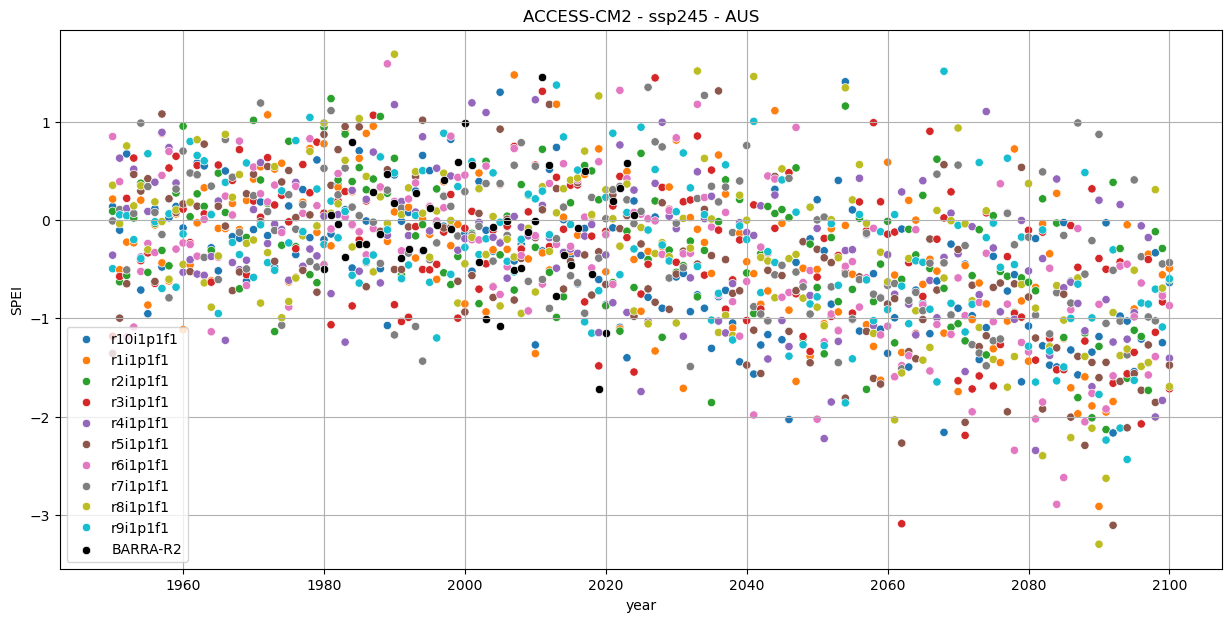

In [7]:
plot_location('ACCESS-CM2', 'ssp245', 'AUS')

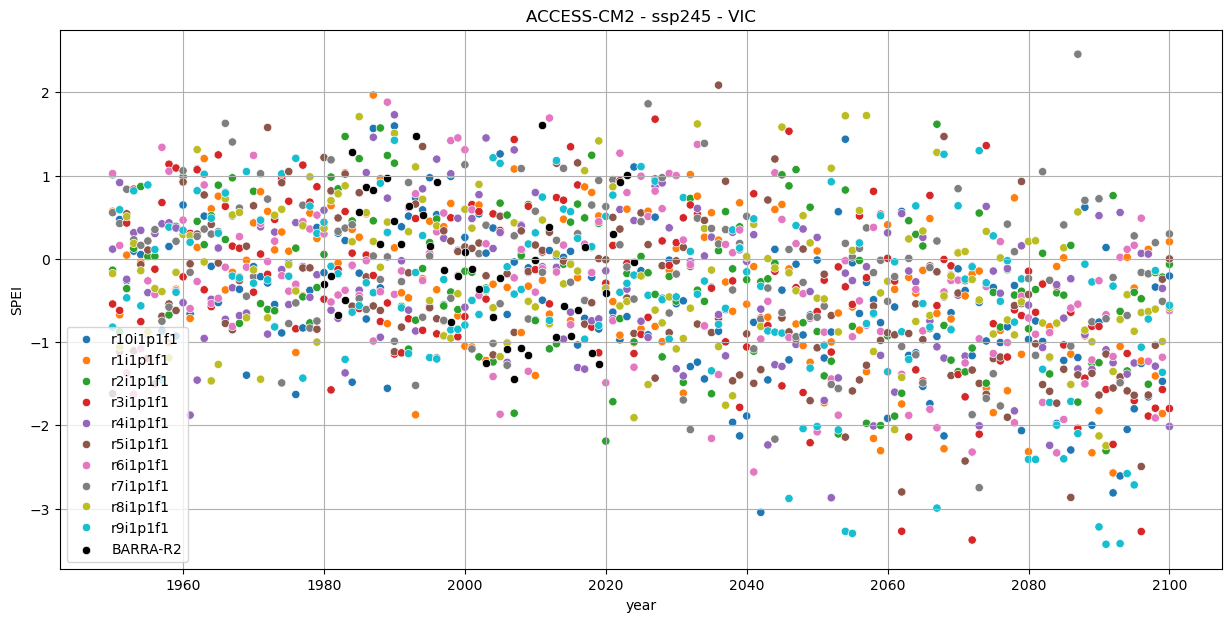

In [8]:
plot_location('ACCESS-CM2', 'ssp245', 'VIC')

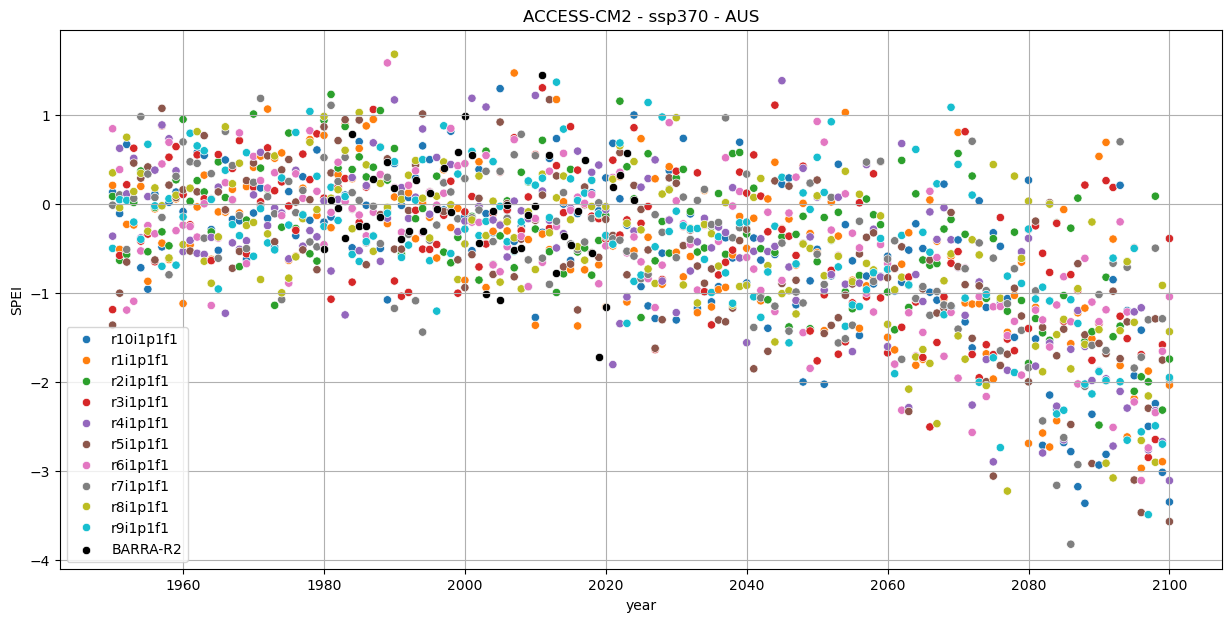

In [9]:
plot_location('ACCESS-CM2', 'ssp370', 'AUS')

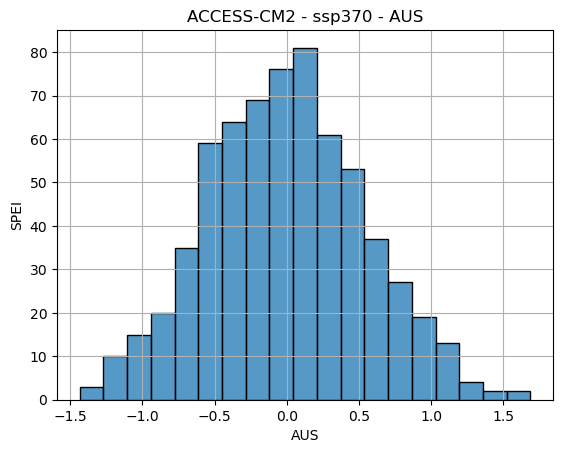

In [10]:
plot_dist('ACCESS-CM2', 'ssp370', 'AUS')

#### MPI-ESM1-2-LR

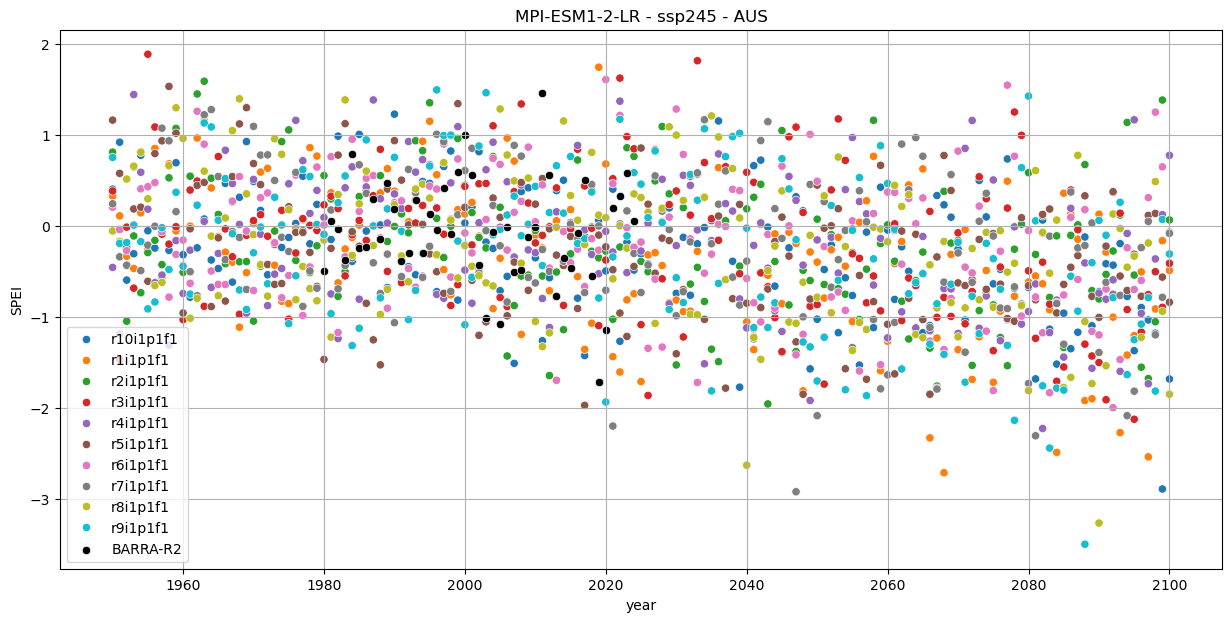

In [11]:
plot_location('MPI-ESM1-2-LR', 'ssp245', 'AUS')

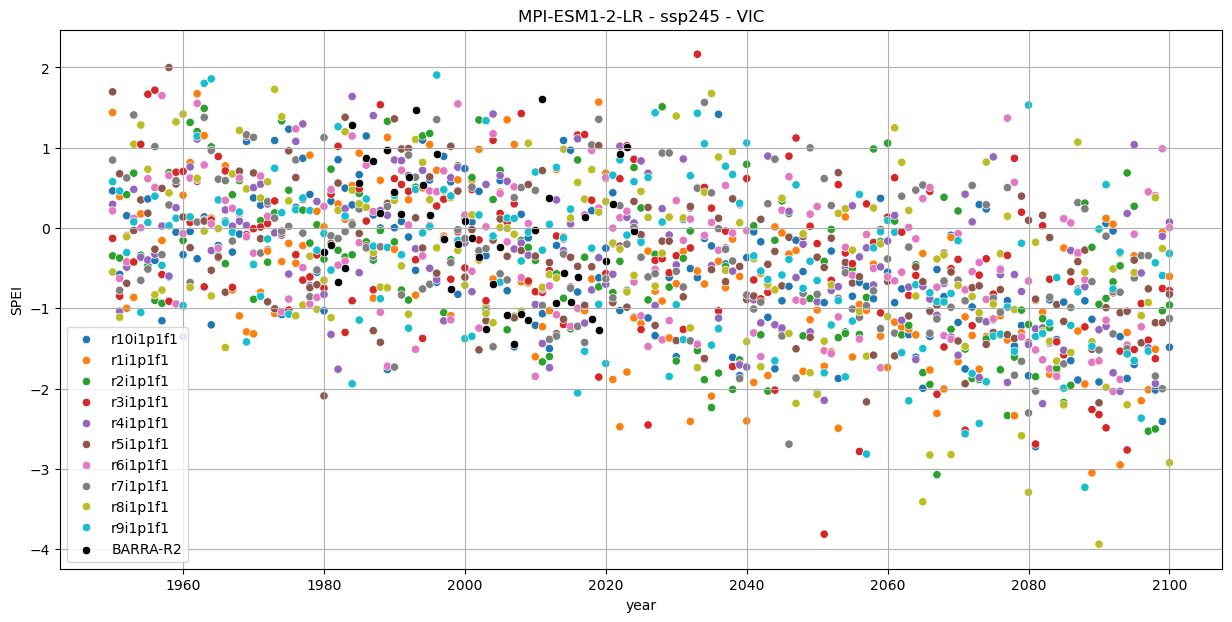

In [12]:
plot_location('MPI-ESM1-2-LR', 'ssp245', 'VIC')

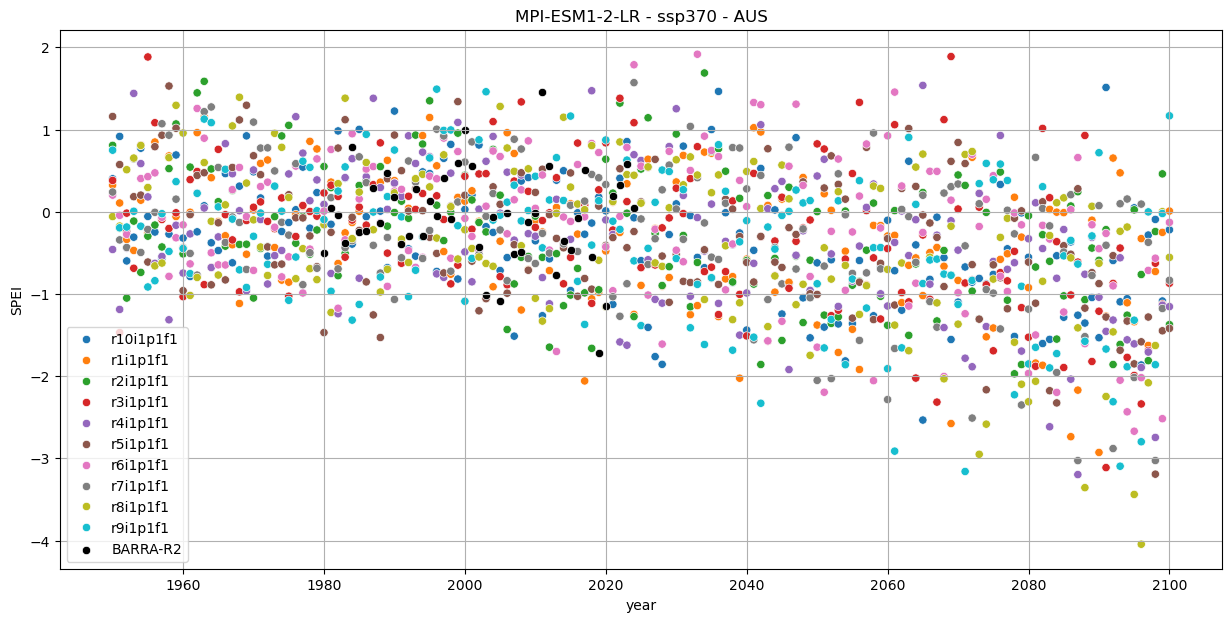

In [13]:
plot_location('MPI-ESM1-2-LR', 'ssp370', 'AUS')

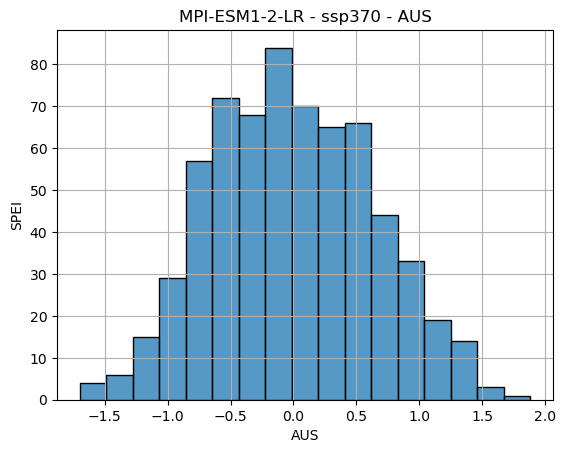

In [14]:
plot_dist('MPI-ESM1-2-LR', 'ssp370', 'AUS')

## Ensemble

In [21]:
colors = {
    'ssp126': 'tab:blue',
    'ssp245': 'tab:green',
    'ssp370': 'tab:orange',
    'ssp585': 'tab:red',
}

linestyles = {
    'ACCESS-CM2': '-',
    'MPI-ESM1-2-LR': ':',
}

return_conversion = {
    '1-in-50 year': '02-0p',
    '1-in-40 year': '02-5p',
    '1-in-30 year': '03-3p',
    '1-in-20 year': '05-0p',
    '1-in-10 year': '10-0p',
}

def plot_ensemble_odds(
    models,
    experiments,
    location,
    return_period,
):
    """Ensemble odds of a year higher than a given return period for a given location."""

    # Plot
    fig, ax = plt.subplots()
    plabel = return_conversion[return_period]
    for model in models:
        for experiment in experiments:
            infile = f'/g/data/xv83/dbi599/rba/SPEI/{model}/{experiment}/spei_yr_{plabel}-likelihood_{model}_{experiment}_aus-states_1860-2091.csv'
            df = pd.read_csv(infile, header=7, index_col='year')
            df = df[location]
            sns.lineplot(
                ax=ax,
                data=df,
                label=f'{model} ({experiment})',
                color=colors[experiment],
                linestyle=linestyles[model],
            )
    ax.set_xlabel('year')
    ax.set_ylabel(f'odds of exceeding {return_period} event (%)') 
    ax.set_title(f'SPEI - {location}')
    ax.grid()
    plt.show()

    # Supporting info
    for model in models:
        pfile = f'/g/data/xv83/dbi599/rba/SPEI/{model}/{experiments[0]}/spei_yr_percentiles_{model}_{experiments[0]}_aus-states_1950-2014.csv' 
        pdf = pd.read_csv(pfile, header=6, index_col='percentile')
        pdf = pdf[location]
        p = float(plabel[0:-1].replace('-', '.'))
        pval = pdf.loc[p]
        print(f'{return_period} event, {model}: {pval}')

    obs = df_barra.set_index('year')
    print('Top 10 years in BARRA-R2:')
    print(obs[location].sort_values(ascending=True)[0:15])

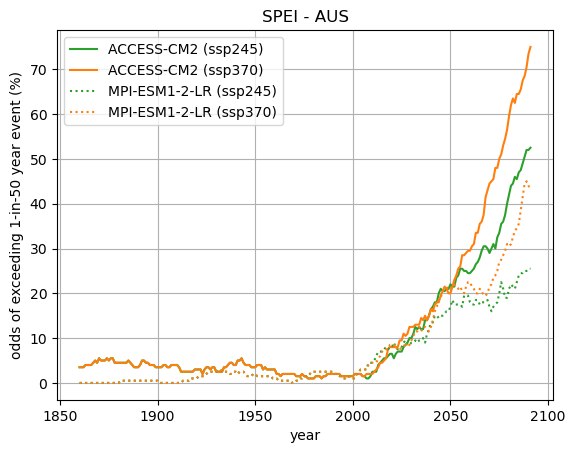

1-in-50 year event, ACCESS-CM2: -1.09
1-in-50 year event, MPI-ESM1-2-LR: -1.23
Top 10 years in BARRA-R2:
year
2019   -1.716667
2020   -1.151667
2005   -1.080000
2003   -1.011667
2013   -0.771667
2018   -0.548333
2007   -0.508333
1980   -0.500000
2008   -0.491667
2015   -0.461667
2002   -0.430833
1991   -0.390000
1983   -0.378333
2014   -0.355000
1994   -0.300833
Name: AUS, dtype: float64


In [22]:
plot_ensemble_odds(
    ['ACCESS-CM2', 'MPI-ESM1-2-LR'],
    ['ssp245', 'ssp370'],
    'AUS',
    '1-in-50 year',
)

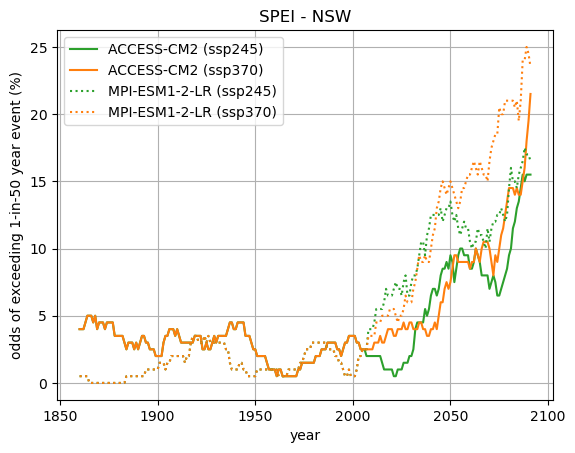

1-in-50 year event, ACCESS-CM2: -1.51
1-in-50 year event, MPI-ESM1-2-LR: -1.55
Top 10 years in BARRA-R2:
year
2019   -1.856667
2018   -1.671667
2003   -1.524167
2007   -1.074167
1980   -1.070000
2002   -1.058333
2006   -0.995833
2014   -0.980000
2004   -0.824167
2020   -0.790833
2013   -0.788333
2005   -0.637500
1983   -0.487500
1981   -0.460833
2009   -0.457500
Name: NSW, dtype: float64


In [23]:
plot_ensemble_odds(
    ['ACCESS-CM2', 'MPI-ESM1-2-LR'],
    ['ssp245', 'ssp370'],
    'NSW',
    '1-in-50 year',
)

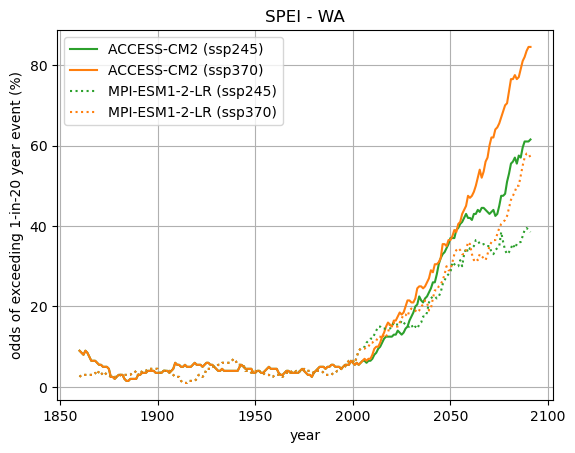

1-in-20 year event, ACCESS-CM2: -1.06
1-in-20 year event, MPI-ESM1-2-LR: -1.1
Top 10 years in BARRA-R2:
year
2019   -1.806667
2020   -1.336667
1991   -1.174167
2005   -1.139167
2010   -1.045000
2003   -0.738333
2024   -0.653333
2008   -0.625833
1994   -0.561667
2007   -0.490000
1986   -0.329167
1998   -0.327500
2015   -0.290833
1983   -0.285000
1988   -0.280833
Name: WA, dtype: float64


In [24]:
plot_ensemble_odds(
    ['ACCESS-CM2', 'MPI-ESM1-2-LR'],
    ['ssp245', 'ssp370'],
    'WA',
    '1-in-20 year',
)